## 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.regularizers import l1, l2, l1_l2
from collections import defaultdict
import matplotlib.pyplot as plt

#%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_data_shape, l2_ratio):
    model = Sequential()
    
    #卷積層1與池化層1
    model.add(Conv2D(filters=256,
                     kernel_size=(3, 3),
                     input_shape=input_data_shape,
                     activation='relu',
                     padding='same'))
    model.add(Dropout(rate=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層2與池化層2
    model.add(Conv2D(filters=128,
                     kernel_size=(3, 3),
                     activation='relu',
                     padding='same'))
    model.add(Dropout(rate=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     #卷積層3與池化層3
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(Dropout(rate=0.2))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     #卷積層3與池化層4
#     model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(Dropout(rate=0.2))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #建立神經網路(平坦層、隱藏層、輸出層)
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_ratio)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(l2_ratio)))

    return model

In [6]:
## 超參數設定
OPTIMIZER = ["sgd", "rmsprop", "adam", "adagrad"]
LEARNING_RATE = 1e-4
L2_EXP = [1e-2, 1e-4, 1e-8]
EPOCHS = 100
BATCH_SIZE = 64
MOMENTUM = 0.95

In [7]:
tra_loss = defaultdict(list)
val_loss = defaultdict(list)
tra_accu = defaultdict(list)
val_accu = defaultdict(list)

for i, l2_ratio in enumerate(L2_EXP):
    for j, optr in enumerate(OPTIMIZER):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer=%s, Learning rate=%.6f, L2=%.9f" % (optr, LEARNING_RATE, l2_ratio))
        
        # create model
        model = build_mlp(x_train.shape[1:], l2_ratio)
        
        # optimizer
        if optr == "sgd":
            optimizer = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=MOMENTUM, nesterov=True)

        if optr == "rmsprop":
            optimizer = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)

        if optr == "adam":
            optimizer = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        if optr == "adagrad":
            optimizer = optimizers.Adagrad(lr=LEARNING_RATE, epsilon=None, decay=0.0)
    
        # compile model and training
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), shuffle=True)

        # Collect results
        loss_tag = "%s:%s" % (("l2_"+str(i)), str(optr))
        tra_loss[loss_tag].append(model.history.history["loss"])
        val_loss[loss_tag].append(model.history.history["val_loss"])
        
        accu_tag = "%s:%s" % (("l2_"+str(i)), str(optr))
        tra_accu[accu_tag].append(model.history.history["acc"])
        val_accu[accu_tag].append(model.history.history["val_acc"])


Experiment with Optimizer=sgd, Learning rate=0.000100, L2=0.010000000
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 54s 1ms/step - loss: 11.7756 - acc: 0.1854 - val_loss: 11.4210 - val_acc: 0.2621
Epoch 2/100
50000/50000 [==============================] - 51s 1ms/step - loss: 11.0054 - acc: 0.2780 - val_loss: 10.7079 - val_acc: 0.3153
Epoch 3/100
50000/50000 [==============================] - 51s 1ms/step - loss: 10.3581 - acc: 0.3220 - val_loss: 10.1244 - val_acc: 0.3469
Epoch 4/100
50000/50000 [==============================] - 51s 1ms/step - loss: 9.7873 - acc: 0.3474 - val_loss: 9.5709 - val_acc: 0.3754
Epoch 5/100
50000/50000 [==============================] - 51s 1ms/step - loss: 9.2522 - acc: 0.3698 - val_loss: 9.0623 - val_acc: 0.3923
Epoch 6/100
50000/50000 [==============================] - 51s 1ms/step - loss: 8.7453 - acc: 0.3917 - val_loss: 8.5766 - val_acc: 0.4138
Epoch 7/100
50000/50000 [=====================

50000/50000 [==============================] - 51s 1ms/step - loss: 1.4572 - acc: 0.6410 - val_loss: 1.5803 - val_acc: 0.6214
Epoch 60/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.4331 - acc: 0.6470 - val_loss: 1.5555 - val_acc: 0.6225
Epoch 61/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.4114 - acc: 0.6487 - val_loss: 1.5603 - val_acc: 0.6279
Epoch 62/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.3970 - acc: 0.6506 - val_loss: 1.5249 - val_acc: 0.6358
Epoch 63/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.3747 - acc: 0.6534 - val_loss: 1.5170 - val_acc: 0.6268
Epoch 64/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.3587 - acc: 0.6539 - val_loss: 1.5035 - val_acc: 0.6348
Epoch 65/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.3422 - acc: 0.6568 - val_loss: 1.4834 - val_acc: 0.6268
Epoch 66/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 1.1830 - acc: 0.6681 - val_loss: 1.3264 - val_acc: 0.6185
Epoch 18/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.1722 - acc: 0.6691 - val_loss: 1.2488 - val_acc: 0.6628
Epoch 19/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.1588 - acc: 0.6754 - val_loss: 1.2926 - val_acc: 0.6310
Epoch 20/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.1474 - acc: 0.6780 - val_loss: 1.3920 - val_acc: 0.5816
Epoch 21/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.1382 - acc: 0.6835 - val_loss: 1.3143 - val_acc: 0.6190
Epoch 22/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.1271 - acc: 0.6884 - val_loss: 1.2818 - val_acc: 0.6503
Epoch 23/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.1181 - acc: 0.6921 - val_loss: 1.2758 - val_acc: 0.6575
Epoch 24/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 0.8221 - acc: 0.8125 - val_loss: 1.0409 - val_acc: 0.7414
Epoch 77/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.8166 - acc: 0.8139 - val_loss: 1.0334 - val_acc: 0.7497
Epoch 78/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.8142 - acc: 0.8164 - val_loss: 1.0125 - val_acc: 0.7500
Epoch 79/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.8093 - acc: 0.8167 - val_loss: 1.0257 - val_acc: 0.7480
Epoch 80/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.8093 - acc: 0.8178 - val_loss: 1.0255 - val_acc: 0.7476
Epoch 81/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.8052 - acc: 0.8178 - val_loss: 1.0566 - val_acc: 0.7342
Epoch 82/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.8022 - acc: 0.8218 - val_loss: 1.0914 - val_acc: 0.7274
Epoch 83/100
50000/50000 [==============

50000/50000 [==============================] - 54s 1ms/step - loss: 0.9915 - acc: 0.7434 - val_loss: 1.1449 - val_acc: 0.7138
Epoch 35/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.9839 - acc: 0.7485 - val_loss: 1.1119 - val_acc: 0.7284
Epoch 36/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.9774 - acc: 0.7495 - val_loss: 1.1398 - val_acc: 0.7216
Epoch 37/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.9696 - acc: 0.7549 - val_loss: 1.1175 - val_acc: 0.7205
Epoch 38/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.9642 - acc: 0.7563 - val_loss: 1.1061 - val_acc: 0.7270
Epoch 39/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.9540 - acc: 0.7594 - val_loss: 1.1022 - val_acc: 0.7294
Epoch 40/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.9447 - acc: 0.7656 - val_loss: 1.1097 - val_acc: 0.7308
Epoch 41/100
50000/50000 [==============

50000/50000 [==============================] - 54s 1ms/step - loss: 0.7094 - acc: 0.8711 - val_loss: 1.0530 - val_acc: 0.7560
Epoch 94/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.7076 - acc: 0.8717 - val_loss: 1.0365 - val_acc: 0.7586
Epoch 95/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.7088 - acc: 0.8718 - val_loss: 1.0845 - val_acc: 0.7443
Epoch 96/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.6991 - acc: 0.8751 - val_loss: 1.0668 - val_acc: 0.7493
Epoch 97/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.7034 - acc: 0.8727 - val_loss: 1.0486 - val_acc: 0.7549
Epoch 98/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.6981 - acc: 0.8757 - val_loss: 1.0550 - val_acc: 0.7538
Epoch 99/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.6964 - acc: 0.8755 - val_loss: 1.0526 - val_acc: 0.7535
Epoch 100/100
50000/50000 [=============

50000/50000 [==============================] - 52s 1ms/step - loss: 3.4859 - acc: 0.4992 - val_loss: 3.5699 - val_acc: 0.5068
Epoch 52/100
50000/50000 [==============================] - 52s 1ms/step - loss: 3.4685 - acc: 0.4998 - val_loss: 3.5540 - val_acc: 0.5095
Epoch 53/100
50000/50000 [==============================] - 52s 1ms/step - loss: 3.4511 - acc: 0.5009 - val_loss: 3.5378 - val_acc: 0.5089
Epoch 54/100
50000/50000 [==============================] - 52s 1ms/step - loss: 3.4348 - acc: 0.5026 - val_loss: 3.5224 - val_acc: 0.5113
Epoch 55/100
50000/50000 [==============================] - 52s 1ms/step - loss: 3.4204 - acc: 0.5029 - val_loss: 3.5083 - val_acc: 0.5082
Epoch 56/100
50000/50000 [==============================] - 52s 1ms/step - loss: 3.4042 - acc: 0.5041 - val_loss: 3.4909 - val_acc: 0.5133
Epoch 57/100
50000/50000 [==============================] - 52s 1ms/step - loss: 3.3910 - acc: 0.5058 - val_loss: 3.4767 - val_acc: 0.5124
Epoch 58/100
50000/50000 [==============

50000/50000 [==============================] - 51s 1ms/step - loss: 1.6348 - acc: 0.4553 - val_loss: 1.6708 - val_acc: 0.4757
Epoch 10/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.5940 - acc: 0.4701 - val_loss: 1.6313 - val_acc: 0.4917
Epoch 11/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.5570 - acc: 0.4827 - val_loss: 1.6038 - val_acc: 0.5014
Epoch 12/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.5283 - acc: 0.4920 - val_loss: 1.5690 - val_acc: 0.5076
Epoch 13/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.5019 - acc: 0.5005 - val_loss: 1.5558 - val_acc: 0.5170
Epoch 14/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.4772 - acc: 0.5108 - val_loss: 1.5281 - val_acc: 0.5219
Epoch 15/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.4550 - acc: 0.5185 - val_loss: 1.5070 - val_acc: 0.5302
Epoch 16/100
50000/50000 [==============

50000/50000 [==============================] - 51s 1ms/step - loss: 0.8834 - acc: 0.7313 - val_loss: 1.0625 - val_acc: 0.6784
Epoch 69/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8759 - acc: 0.7317 - val_loss: 1.0574 - val_acc: 0.6785
Epoch 70/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8684 - acc: 0.7341 - val_loss: 1.0559 - val_acc: 0.6817
Epoch 71/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8574 - acc: 0.7383 - val_loss: 1.0563 - val_acc: 0.6758
Epoch 72/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8514 - acc: 0.7414 - val_loss: 1.0558 - val_acc: 0.6830
Epoch 73/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8428 - acc: 0.7428 - val_loss: 1.0567 - val_acc: 0.6785
Epoch 74/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.8361 - acc: 0.7450 - val_loss: 1.0537 - val_acc: 0.6845
Epoch 75/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 0.3401 - acc: 0.9225 - val_loss: 0.8777 - val_acc: 0.7459
Epoch 27/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.3263 - acc: 0.9268 - val_loss: 0.8498 - val_acc: 0.7578
Epoch 28/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.3160 - acc: 0.9310 - val_loss: 0.9419 - val_acc: 0.7261
Epoch 29/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.3064 - acc: 0.9359 - val_loss: 0.8517 - val_acc: 0.7601
Epoch 30/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2960 - acc: 0.9397 - val_loss: 0.8792 - val_acc: 0.7572
Epoch 31/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2850 - acc: 0.9429 - val_loss: 0.9155 - val_acc: 0.7431
Epoch 32/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2819 - acc: 0.9463 - val_loss: 0.8808 - val_acc: 0.7537
Epoch 33/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 0.2904 - acc: 0.9513 - val_loss: 1.0931 - val_acc: 0.7701
Epoch 86/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2969 - acc: 0.9494 - val_loss: 1.0706 - val_acc: 0.7680
Epoch 87/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2927 - acc: 0.9499 - val_loss: 1.2136 - val_acc: 0.7246
Epoch 88/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2952 - acc: 0.9506 - val_loss: 1.1257 - val_acc: 0.7242
Epoch 89/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2969 - acc: 0.9497 - val_loss: 1.1654 - val_acc: 0.7470
Epoch 90/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2958 - acc: 0.9501 - val_loss: 1.0283 - val_acc: 0.7420
Epoch 91/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2991 - acc: 0.9481 - val_loss: 1.1000 - val_acc: 0.7617
Epoch 92/100
50000/50000 [==============

50000/50000 [==============================] - 54s 1ms/step - loss: 0.1686 - acc: 0.9801 - val_loss: 0.9339 - val_acc: 0.7553
Epoch 44/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1681 - acc: 0.9795 - val_loss: 0.9510 - val_acc: 0.7627
Epoch 45/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1671 - acc: 0.9801 - val_loss: 0.9344 - val_acc: 0.7596
Epoch 46/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1613 - acc: 0.9822 - val_loss: 0.9507 - val_acc: 0.7590
Epoch 47/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1589 - acc: 0.9830 - val_loss: 0.9213 - val_acc: 0.7591
Epoch 48/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1573 - acc: 0.9831 - val_loss: 0.9285 - val_acc: 0.7598
Epoch 49/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1589 - acc: 0.9826 - val_loss: 0.9446 - val_acc: 0.7540
Epoch 50/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 2.0762 - acc: 0.3054 - val_loss: 2.0124 - val_acc: 0.3798
Epoch 2/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.8946 - acc: 0.3704 - val_loss: 1.9214 - val_acc: 0.4027
Epoch 3/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.8245 - acc: 0.3937 - val_loss: 1.8703 - val_acc: 0.4182
Epoch 4/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7818 - acc: 0.4089 - val_loss: 1.8351 - val_acc: 0.4282
Epoch 5/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7518 - acc: 0.4181 - val_loss: 1.8087 - val_acc: 0.4371
Epoch 6/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7245 - acc: 0.4273 - val_loss: 1.7880 - val_acc: 0.4414
Epoch 7/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.7070 - acc: 0.4319 - val_loss: 1.7728 - val_acc: 0.4452
Epoch 8/100
50000/50000 [=====================

50000/50000 [==============================] - 52s 1ms/step - loss: 1.4359 - acc: 0.5252 - val_loss: 1.5194 - val_acc: 0.5331
Epoch 61/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4340 - acc: 0.5285 - val_loss: 1.5174 - val_acc: 0.5324
Epoch 62/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4299 - acc: 0.5271 - val_loss: 1.5150 - val_acc: 0.5363
Epoch 63/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4306 - acc: 0.5265 - val_loss: 1.5123 - val_acc: 0.5374
Epoch 64/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4277 - acc: 0.5279 - val_loss: 1.5119 - val_acc: 0.5351
Epoch 65/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4258 - acc: 0.5309 - val_loss: 1.5112 - val_acc: 0.5356
Epoch 66/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.4254 - acc: 0.5309 - val_loss: 1.5078 - val_acc: 0.5375
Epoch 67/100
50000/50000 [==============

50000/50000 [==============================] - 51s 1ms/step - loss: 1.3020 - acc: 0.5399 - val_loss: 1.3735 - val_acc: 0.5449
Epoch 19/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.2843 - acc: 0.5446 - val_loss: 1.3342 - val_acc: 0.5543
Epoch 20/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.2667 - acc: 0.5522 - val_loss: 1.3215 - val_acc: 0.5622
Epoch 21/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.2524 - acc: 0.5564 - val_loss: 1.3139 - val_acc: 0.5591
Epoch 22/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.2383 - acc: 0.5632 - val_loss: 1.2956 - val_acc: 0.5713
Epoch 23/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.2215 - acc: 0.5685 - val_loss: 1.2885 - val_acc: 0.5703
Epoch 24/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.2094 - acc: 0.5718 - val_loss: 1.2720 - val_acc: 0.5755
Epoch 25/100
50000/50000 [==============

50000/50000 [==============================] - 51s 1ms/step - loss: 0.7065 - acc: 0.7555 - val_loss: 0.9189 - val_acc: 0.6970
Epoch 78/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.7016 - acc: 0.7582 - val_loss: 0.9140 - val_acc: 0.6983
Epoch 79/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.6941 - acc: 0.7593 - val_loss: 0.9103 - val_acc: 0.6996
Epoch 80/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.6886 - acc: 0.7617 - val_loss: 0.9095 - val_acc: 0.6951
Epoch 81/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.6799 - acc: 0.7643 - val_loss: 0.8986 - val_acc: 0.6987
Epoch 82/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.6777 - acc: 0.7655 - val_loss: 0.9045 - val_acc: 0.6987
Epoch 83/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.6672 - acc: 0.7699 - val_loss: 0.8993 - val_acc: 0.7002
Epoch 84/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 0.1383 - acc: 0.9556 - val_loss: 0.9166 - val_acc: 0.7591
Epoch 36/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1347 - acc: 0.9565 - val_loss: 0.9192 - val_acc: 0.7656
Epoch 37/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1317 - acc: 0.9575 - val_loss: 0.9664 - val_acc: 0.7611
Epoch 38/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1272 - acc: 0.9602 - val_loss: 1.1132 - val_acc: 0.7478
Epoch 39/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1233 - acc: 0.9610 - val_loss: 1.0235 - val_acc: 0.7569
Epoch 40/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1210 - acc: 0.9617 - val_loss: 0.9927 - val_acc: 0.7448
Epoch 41/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1232 - acc: 0.9609 - val_loss: 1.0877 - val_acc: 0.7430
Epoch 42/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 0.1352 - acc: 0.9579 - val_loss: 1.3266 - val_acc: 0.7602
Epoch 95/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1409 - acc: 0.9566 - val_loss: 1.1367 - val_acc: 0.7498
Epoch 96/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1409 - acc: 0.9557 - val_loss: 1.3113 - val_acc: 0.7338
Epoch 97/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1336 - acc: 0.9584 - val_loss: 1.2580 - val_acc: 0.7606
Epoch 98/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1297 - acc: 0.9602 - val_loss: 1.5089 - val_acc: 0.7577
Epoch 99/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1342 - acc: 0.9578 - val_loss: 1.1739 - val_acc: 0.7199
Epoch 100/100
50000/50000 [==============================] - 52s 1ms/step - loss: 0.1343 - acc: 0.9583 - val_loss: 1.1861 - val_acc: 0.7596
Experiment with Optimizer=adam, Learnin

50000/50000 [==============================] - 54s 1ms/step - loss: 0.0388 - acc: 0.9884 - val_loss: 0.9866 - val_acc: 0.7561
Epoch 53/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0348 - acc: 0.9896 - val_loss: 0.9952 - val_acc: 0.7513
Epoch 54/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0340 - acc: 0.9892 - val_loss: 0.9818 - val_acc: 0.7602
Epoch 55/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0344 - acc: 0.9894 - val_loss: 0.9953 - val_acc: 0.7600
Epoch 56/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0303 - acc: 0.9908 - val_loss: 0.9772 - val_acc: 0.7596
Epoch 57/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0317 - acc: 0.9898 - val_loss: 0.9681 - val_acc: 0.7597
Epoch 58/100
50000/50000 [==============================] - 54s 1ms/step - loss: 0.0296 - acc: 0.9911 - val_loss: 0.9896 - val_acc: 0.7621
Epoch 59/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 1.5674 - acc: 0.4519 - val_loss: 1.6347 - val_acc: 0.4653
Epoch 11/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5553 - acc: 0.4540 - val_loss: 1.6277 - val_acc: 0.4670
Epoch 12/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5469 - acc: 0.4574 - val_loss: 1.6185 - val_acc: 0.4691
Epoch 13/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5341 - acc: 0.4629 - val_loss: 1.6062 - val_acc: 0.4774
Epoch 14/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5263 - acc: 0.4643 - val_loss: 1.5992 - val_acc: 0.4768
Epoch 15/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5180 - acc: 0.4671 - val_loss: 1.5944 - val_acc: 0.4763
Epoch 16/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.5101 - acc: 0.4689 - val_loss: 1.5843 - val_acc: 0.4850
Epoch 17/100
50000/50000 [==============

50000/50000 [==============================] - 52s 1ms/step - loss: 1.3251 - acc: 0.5362 - val_loss: 1.4100 - val_acc: 0.5447
Epoch 70/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3232 - acc: 0.5401 - val_loss: 1.4066 - val_acc: 0.5481
Epoch 71/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3199 - acc: 0.5383 - val_loss: 1.4058 - val_acc: 0.5489
Epoch 72/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3188 - acc: 0.5396 - val_loss: 1.4042 - val_acc: 0.5467
Epoch 73/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3181 - acc: 0.5387 - val_loss: 1.4010 - val_acc: 0.5496
Epoch 74/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3161 - acc: 0.5392 - val_loss: 1.4000 - val_acc: 0.5503
Epoch 75/100
50000/50000 [==============================] - 52s 1ms/step - loss: 1.3136 - acc: 0.5409 - val_loss: 1.3990 - val_acc: 0.5509
Epoch 76/100
50000/50000 [==============

## Plot loss history

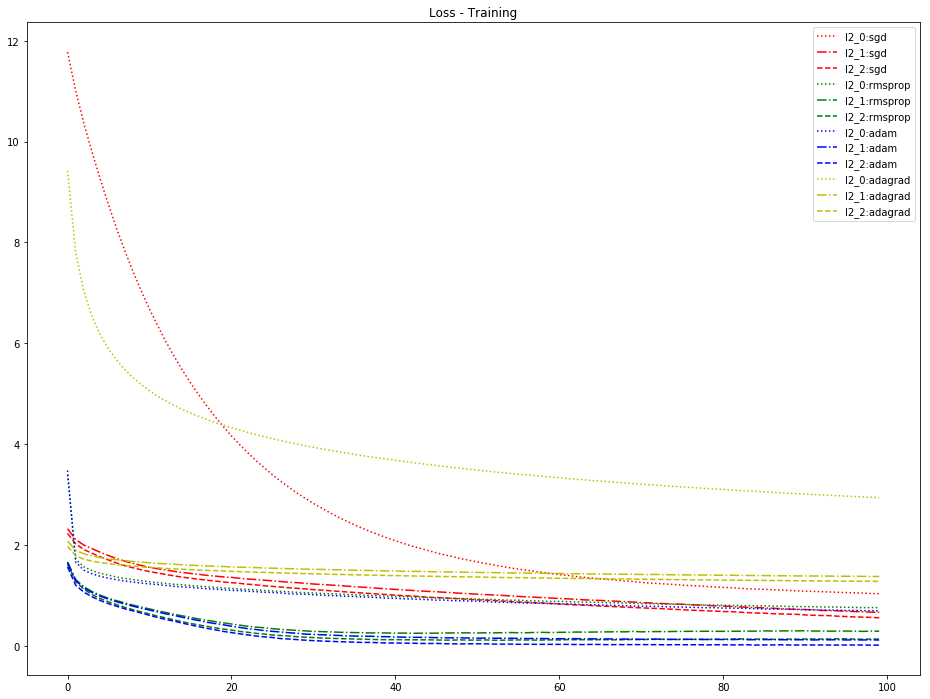

In [8]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(tra_loss["l2_0:sgd"][0])), tra_loss["l2_0:sgd"][0], ':' , label="l2_0:sgd", color="r")
plt.plot(range(len(tra_loss["l2_1:sgd"][0])), tra_loss["l2_1:sgd"][0], '-.', label="l2_1:sgd", color="r")
plt.plot(range(len(tra_loss["l2_2:sgd"][0])), tra_loss["l2_2:sgd"][0], '--', label="l2_2:sgd", color="r")

plt.plot(range(len(tra_loss["l2_0:rmsprop"][0])), tra_loss["l2_0:rmsprop"][0], ':' , label="l2_0:rmsprop", color="g")
plt.plot(range(len(tra_loss["l2_1:rmsprop"][0])), tra_loss["l2_1:rmsprop"][0], '-.', label="l2_1:rmsprop", color="g")
plt.plot(range(len(tra_loss["l2_2:rmsprop"][0])), tra_loss["l2_2:rmsprop"][0], '--', label="l2_2:rmsprop", color="g")

plt.plot(range(len(tra_loss["l2_0:adam"][0])), tra_loss["l2_0:adam"][0], ':' , label="l2_0:adam", color="b")
plt.plot(range(len(tra_loss["l2_1:adam"][0])), tra_loss["l2_1:adam"][0], '-.', label="l2_1:adam", color="b")
plt.plot(range(len(tra_loss["l2_2:adam"][0])), tra_loss["l2_2:adam"][0], '--', label="l2_2:adam", color="b")

plt.plot(range(len(tra_loss["l2_0:adagrad"][0])), tra_loss["l2_0:adagrad"][0], ':' , label="l2_0:adagrad", color="y")
plt.plot(range(len(tra_loss["l2_1:adagrad"][0])), tra_loss["l2_1:adagrad"][0], '-.', label="l2_1:adagrad", color="y")
plt.plot(range(len(tra_loss["l2_2:adagrad"][0])), tra_loss["l2_2:adagrad"][0], '--', label="l2_2:adagrad", color="y")

plt.title("Loss - Training")
plt.legend(loc="upper right")
plt.show()

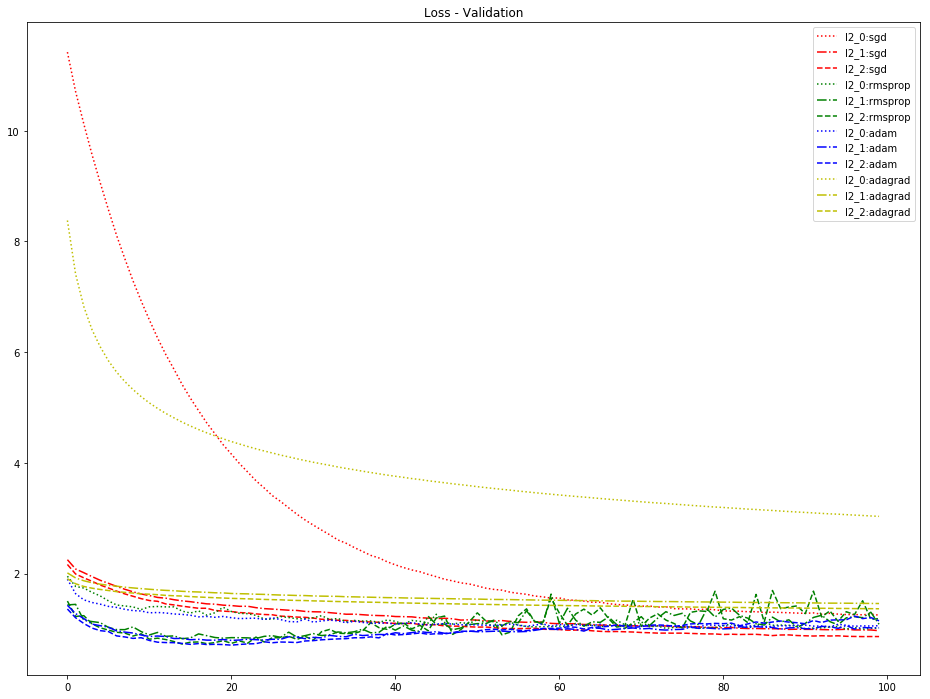

In [9]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(val_loss["l2_0:sgd"][0])), val_loss["l2_0:sgd"][0], ':' , label="l2_0:sgd", color="r")
plt.plot(range(len(val_loss["l2_1:sgd"][0])), val_loss["l2_1:sgd"][0], '-.', label="l2_1:sgd", color="r")
plt.plot(range(len(val_loss["l2_2:sgd"][0])), val_loss["l2_2:sgd"][0], '--', label="l2_2:sgd", color="r")

plt.plot(range(len(val_loss["l2_0:rmsprop"][0])), val_loss["l2_0:rmsprop"][0], ':' , label="l2_0:rmsprop", color="g")
plt.plot(range(len(val_loss["l2_1:rmsprop"][0])), val_loss["l2_1:rmsprop"][0], '-.', label="l2_1:rmsprop", color="g")
plt.plot(range(len(val_loss["l2_2:rmsprop"][0])), val_loss["l2_2:rmsprop"][0], '--', label="l2_2:rmsprop", color="g")

plt.plot(range(len(val_loss["l2_0:adam"][0])), val_loss["l2_0:adam"][0], ':' , label="l2_0:adam", color="b")
plt.plot(range(len(val_loss["l2_1:adam"][0])), val_loss["l2_1:adam"][0], '-.', label="l2_1:adam", color="b")
plt.plot(range(len(val_loss["l2_2:adam"][0])), val_loss["l2_2:adam"][0], '--', label="l2_2:adam", color="b")

plt.plot(range(len(val_loss["l2_0:adagrad"][0])), val_loss["l2_0:adagrad"][0], ':' , label="l2_0:adagrad", color="y")
plt.plot(range(len(val_loss["l2_1:adagrad"][0])), val_loss["l2_1:adagrad"][0], '-.', label="l2_1:adagrad", color="y")
plt.plot(range(len(val_loss["l2_2:adagrad"][0])), val_loss["l2_2:adagrad"][0], '--', label="l2_2:adagrad", color="y")

plt.title("Loss - Validation")
plt.legend(loc="upper right")
plt.show()

### Optimizer=Adam, l2=1e-4 有較低的loss

## Plot accu history

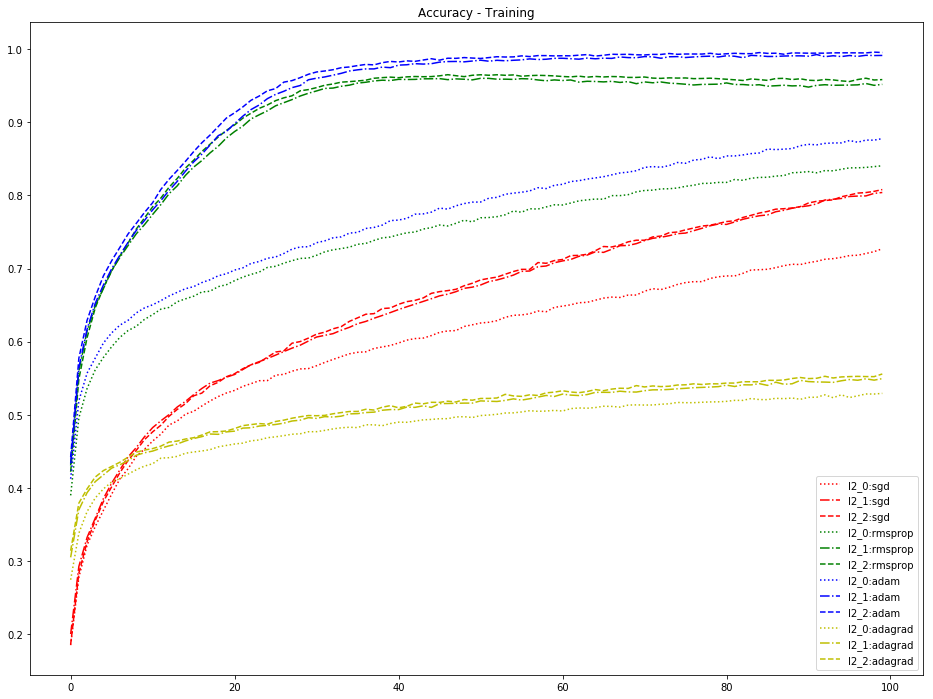

In [10]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(tra_accu["l2_0:sgd"][0])), tra_accu["l2_0:sgd"][0], ':' , label="l2_0:sgd", color="r")
plt.plot(range(len(tra_accu["l2_1:sgd"][0])), tra_accu["l2_1:sgd"][0], '-.', label="l2_1:sgd", color="r")
plt.plot(range(len(tra_accu["l2_2:sgd"][0])), tra_accu["l2_2:sgd"][0], '--', label="l2_2:sgd", color="r")

plt.plot(range(len(tra_accu["l2_0:rmsprop"][0])), tra_accu["l2_0:rmsprop"][0], ':' , label="l2_0:rmsprop", color="g")
plt.plot(range(len(tra_accu["l2_1:rmsprop"][0])), tra_accu["l2_1:rmsprop"][0], '-.', label="l2_1:rmsprop", color="g")
plt.plot(range(len(tra_accu["l2_2:rmsprop"][0])), tra_accu["l2_2:rmsprop"][0], '--', label="l2_2:rmsprop", color="g")

plt.plot(range(len(tra_accu["l2_0:adam"][0])), tra_accu["l2_0:adam"][0], ':' , label="l2_0:adam", color="b")
plt.plot(range(len(tra_accu["l2_1:adam"][0])), tra_accu["l2_1:adam"][0], '-.', label="l2_1:adam", color="b")
plt.plot(range(len(tra_accu["l2_2:adam"][0])), tra_accu["l2_2:adam"][0], '--', label="l2_2:adam", color="b")

plt.plot(range(len(tra_accu["l2_0:adagrad"][0])), tra_accu["l2_0:adagrad"][0], ':' , label="l2_0:adagrad", color="y")
plt.plot(range(len(tra_accu["l2_1:adagrad"][0])), tra_accu["l2_1:adagrad"][0], '-.', label="l2_1:adagrad", color="y")
plt.plot(range(len(tra_accu["l2_2:adagrad"][0])), tra_accu["l2_2:adagrad"][0], '--', label="l2_2:adagrad", color="y")

plt.title("Accuracy - Training")
plt.legend(loc="lower right")
plt.show()

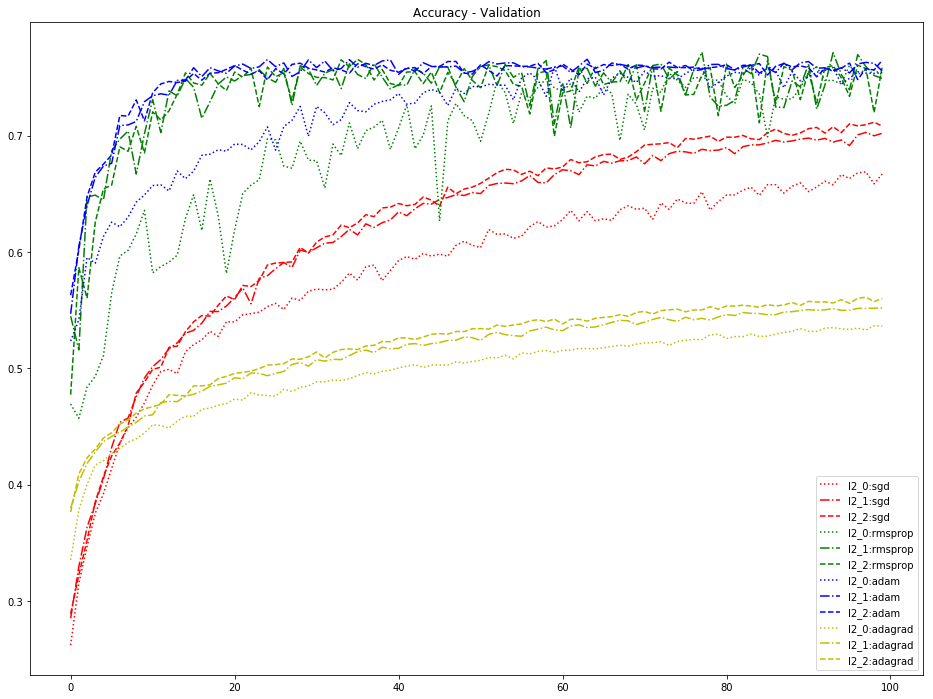

In [11]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(val_accu["l2_0:sgd"][0])), val_accu["l2_0:sgd"][0], ':' , label="l2_0:sgd", color="r")
plt.plot(range(len(val_accu["l2_1:sgd"][0])), val_accu["l2_1:sgd"][0], '-.', label="l2_1:sgd", color="r")
plt.plot(range(len(val_accu["l2_2:sgd"][0])), val_accu["l2_2:sgd"][0], '--', label="l2_2:sgd", color="r")

plt.plot(range(len(val_accu["l2_0:rmsprop"][0])), val_accu["l2_0:rmsprop"][0], ':' , label="l2_0:rmsprop", color="g")
plt.plot(range(len(val_accu["l2_1:rmsprop"][0])), val_accu["l2_1:rmsprop"][0], '-.', label="l2_1:rmsprop", color="g")
plt.plot(range(len(val_accu["l2_2:rmsprop"][0])), val_accu["l2_2:rmsprop"][0], '--', label="l2_2:rmsprop", color="g")

plt.plot(range(len(val_accu["l2_0:adam"][0])), val_accu["l2_0:adam"][0], ':' , label="l2_0:adam", color="b")
plt.plot(range(len(val_accu["l2_1:adam"][0])), val_accu["l2_1:adam"][0], '-.', label="l2_1:adam", color="b")
plt.plot(range(len(val_accu["l2_2:adam"][0])), val_accu["l2_2:adam"][0], '--', label="l2_2:adam", color="b")

plt.plot(range(len(val_accu["l2_0:adagrad"][0])), val_accu["l2_0:adagrad"][0], ':' , label="l2_0:adagrad", color="y")
plt.plot(range(len(val_accu["l2_1:adagrad"][0])), val_accu["l2_1:adagrad"][0], '-.', label="l2_1:adagrad", color="y")
plt.plot(range(len(val_accu["l2_2:adagrad"][0])), val_accu["l2_2:adagrad"][0], '--', label="l2_2:adagrad", color="y")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

### Optimizer=Adam, lr=1e-4有較好的準確率

In [12]:
## '-' solid line style
## '--' dashed line style
## '-.' dash-dot line style
## ':' dotted line style
## '.' point marker
## ',' pixel marker
## 'o' circle marker
## 'v' triangle_down marker
## '^' triangle_up marker
## '<' triangle_left marker
## '>' triangle_right marker
## '1' tri_down marker
## '2' tri_up marker
## '3' tri_left marker
## '4' tri_right marker
## 's' square marker
## 'p' pentagon marker
## '*' star marker
## 'h' hexagon1 marker
## 'H' hexagon2 marker
## '+' plus marker
## 'x' x marker
## 'D' diamond marker
## 'd' thin_diamond marker
## '|' vline marker
## '_' hline marker
## 
## 'b' blue
## 'g' green
## 'r' red
## 'c' cyan
## 'm' magenta
## 'y' yellow
## 'k' black
## 'w' white